# Sprawozdanie - MOwNiT - laboratorium 4.

#### Autor: Jakub Psarski

## 1. Aproksymacja TSP z wykorzystaniem symulowanego wyżarzania

Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.
- Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
- Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap vs. arbitrary swap) oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji.
- Przedstaw wizualizację działania procedury minimalizującej funkcję celu.

### Importowanie potrzebnych bibliotek

In [1]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np

### Implementacja algorytmu symulowanego wyżarzania dla TSP

In [2]:
def simulated_annealing(points, temperature=100, cooling_rate=0.995, threshold=1e-2, swap_type="arbitrary"):
    n = len(points)
    dist_matrix = distance_matrix(points)

    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_length = tour_length(current_tour, dist_matrix)

    initial_tour = current_tour.copy()
    initial_length = current_length

    best_tour = current_tour.copy()
    best_length = current_length
    found_time = t_0 = time.perf_counter()

    lengths = [(0, initial_length)]
    temps = [(0, temperature)]

    while temperature > threshold:
        for _ in range(100):
            match swap_type:
                case "consecutive":
                    i = random.randint(0, n-2)
                    j = i + 1
                case "arbitrary":
                    i, j = random.sample(range(n), 2)

            new_tour = current_tour.copy()
            new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
            new_length = tour_length(new_tour, dist_matrix)

            if new_length < current_length or random.random() < math.exp((current_length - new_length) / temperature):
                current_tour = new_tour
                current_length = new_length

                if new_length < best_length:
                    best_tour = new_tour
                    best_length = new_length
                    found_time = time.perf_counter() - t_0

            lengths.append((time.perf_counter() - t_0, current_length))

        temperature *= cooling_rate
        temps.append((time.perf_counter() - t_0, temperature))

    return best_tour, best_length, found_time, initial_tour, initial_length, lengths, temps


### Funkcje pomocnicze

- `generate_points()` - generowanie chmury punktów zgodnie z podanymi parametrami

In [3]:
def generate_points(n, distribution="uniform"):
    match distribution:
        case "uniform":
            return np.random.rand(n, 2) * 100
        case "normal":
            centers = [(25, 25), (25, 75), (75, 25), (75, 75)]
            points = []
            for _ in range(n):
                center = random.choice(centers)
                points.append(np.random.normal(loc=center, scale=10, size=(1, 2))[0])
            return np.array(points)
        case "clusters":
            clusters = [(10, 10), (90, 90), (10, 90), (90, 10), (50, 50), (25, 75), (75, 25), (25, 25), (75, 75)]
            points = []
            for _ in range(n):
                cluster = random.choice(clusters)
                points.append(np.random.normal(loc=cluster, scale=5, size=(1, 2))[0])
            return np.array(points)

- `distance_matrix()` - generowanie macierzy zawierającej odległości między każdą parą punktów

In [4]:
def distance_matrix(points):
    n = len(points)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.linalg.norm(points[i] - points[j])
    return dist_matrix

- `tour_length()` - obliczanie długości danej drogi na podstawie macierzy odległości (funkcja kosztu)

In [5]:
def tour_length(tour, dist_matrix):
    return sum(dist_matrix[tour[i], tour[i + 1]] for i in range(len(tour) - 1)) + dist_matrix[tour[-1], tour[0]]

- `plot_tour()`, `plot_length()`, `plot_temperature()`, `plot_results()` - wizualizacja wyników oraz parametrów

In [6]:
def plot_tour(ax, points, tour, title):
    ordered_points = np.array([points[i] for i in tour] + [points[tour[0]]])
    ax.set_title(title)
    ax.plot(ordered_points[:, 0], ordered_points[:, 1], 'bo-')
    ax.scatter(points[:, 0], points[:, 1], c='red')


def plot_length(ax, lengths, title):
    x_values, y_values = zip(*lengths)
    ax.plot(x_values, y_values, color='green', lw=0.2)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Tour length")


def plot_temperature(ax, temps, title):
    x_values, y_values = zip(*temps)
    ax.plot(x_values, y_values, color='red', lw=1)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Temperature")


def plot_results(points, best_tour, best_length, found_time, initial_tour, initial_length, lengths, temps, n, dist):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"TSP solution for n={n}, distribution: {dist}", fontsize=16)

    plot_tour(axs[0, 0], points, initial_tour, title=f"Before annealing: length = {initial_length:.2f}")
    plot_tour(axs[0, 1], points, best_tour, title=f"After annealing: length = {best_length:.2f}, found in {found_time:.2f}s")
    plot_length(axs[1, 0], lengths, title="Tour length over iterations")
    plot_temperature(axs[1, 1], temps, title="Temperature over iterations")

    plt.show()

### Wyniki, czasy działania, wizualizacja

n=20
Distribution: uniform
Best tour length: 400.03, found in 0.52s
Total elapsed time: 1.47s



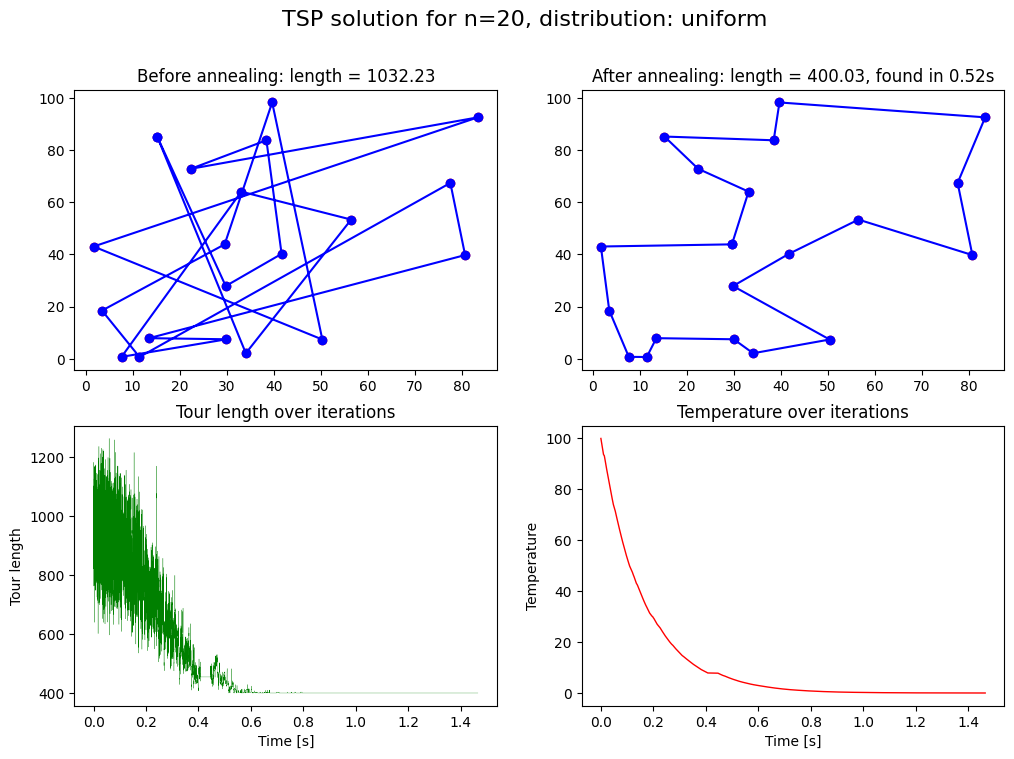

n=20
Distribution: normal
Best tour length: 321.58, found in 0.48s
Total elapsed time: 1.48s



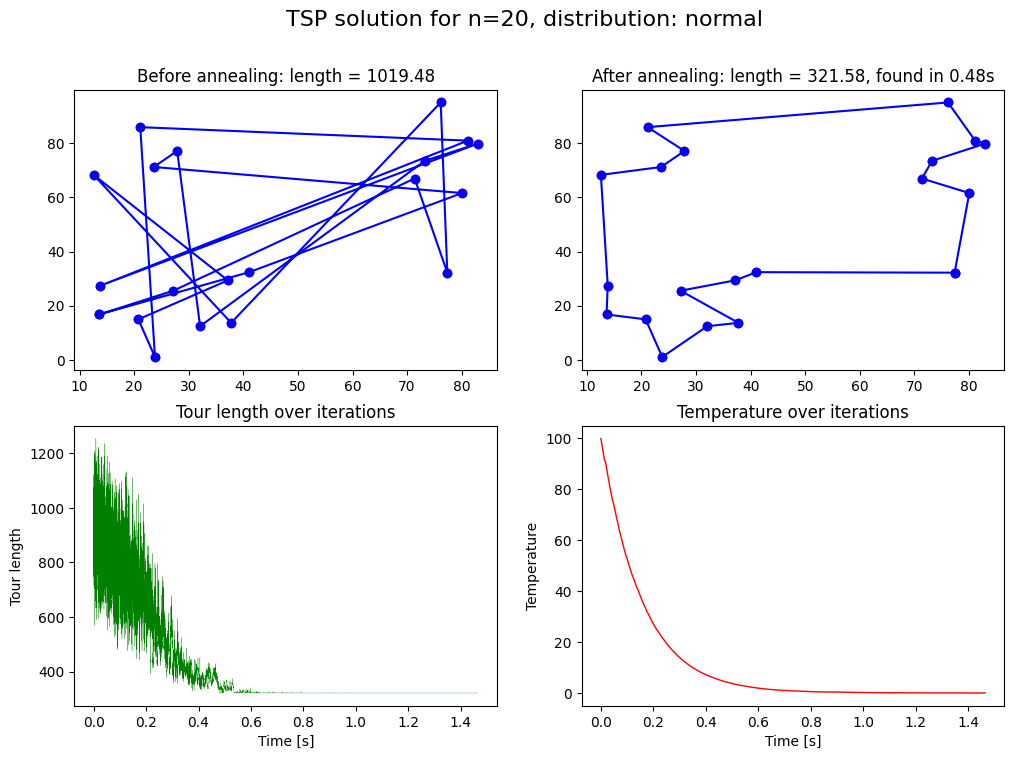

n=20
Distribution: clusters
Best tour length: 412.85, found in 0.33s
Total elapsed time: 1.50s



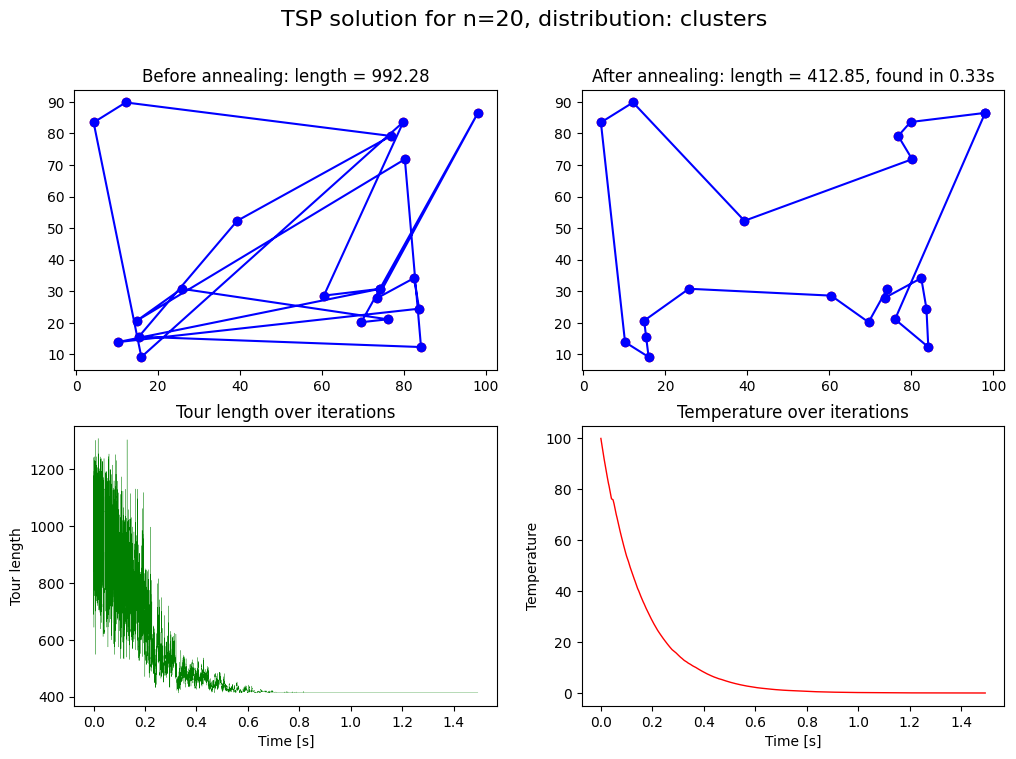

n=50
Distribution: uniform
Best tour length: 661.08, found in 1.49s
Total elapsed time: 2.68s



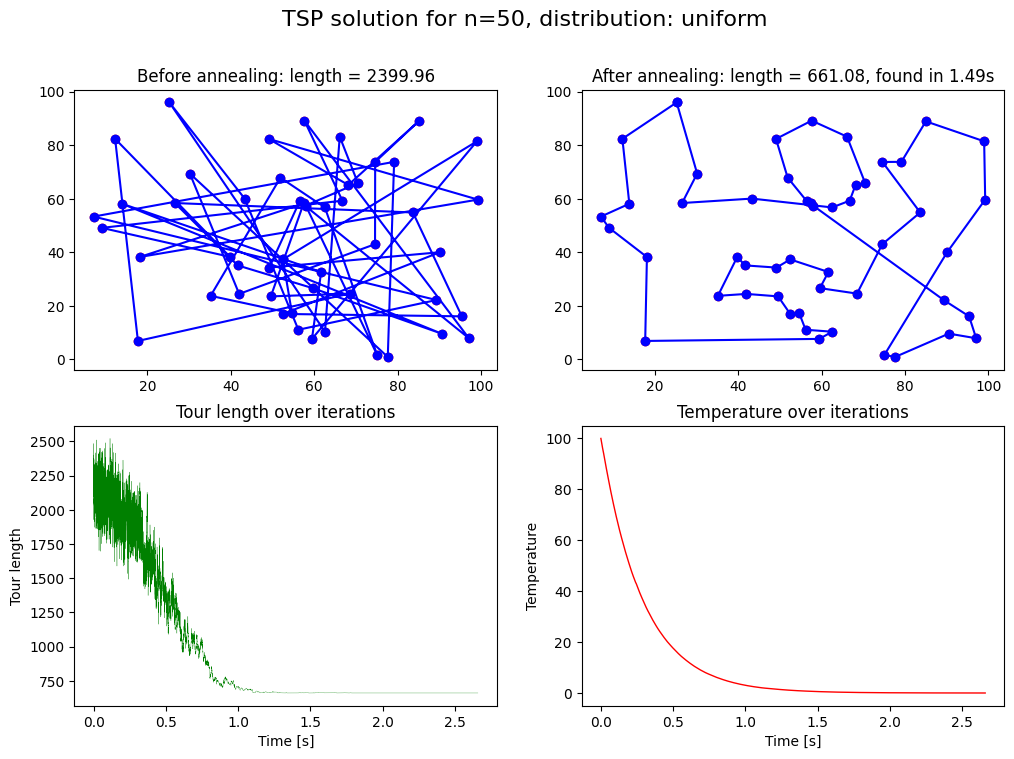

n=50
Distribution: normal
Best tour length: 572.56, found in 1.49s
Total elapsed time: 2.68s



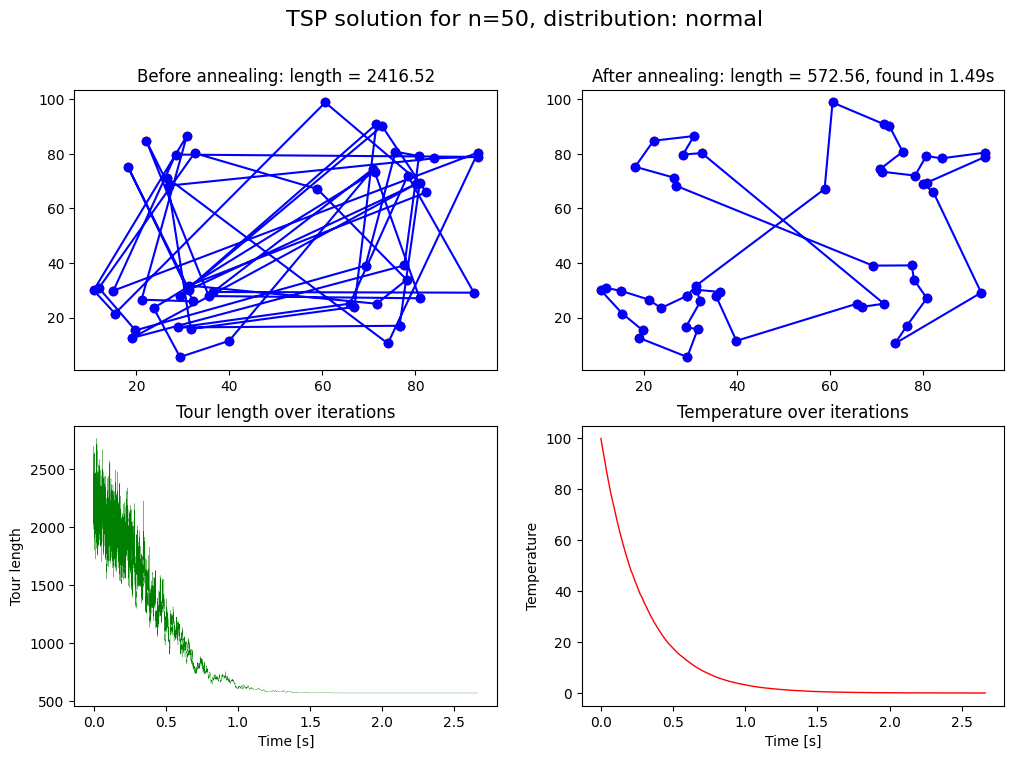

n=50
Distribution: clusters
Best tour length: 528.54, found in 1.56s
Total elapsed time: 2.76s



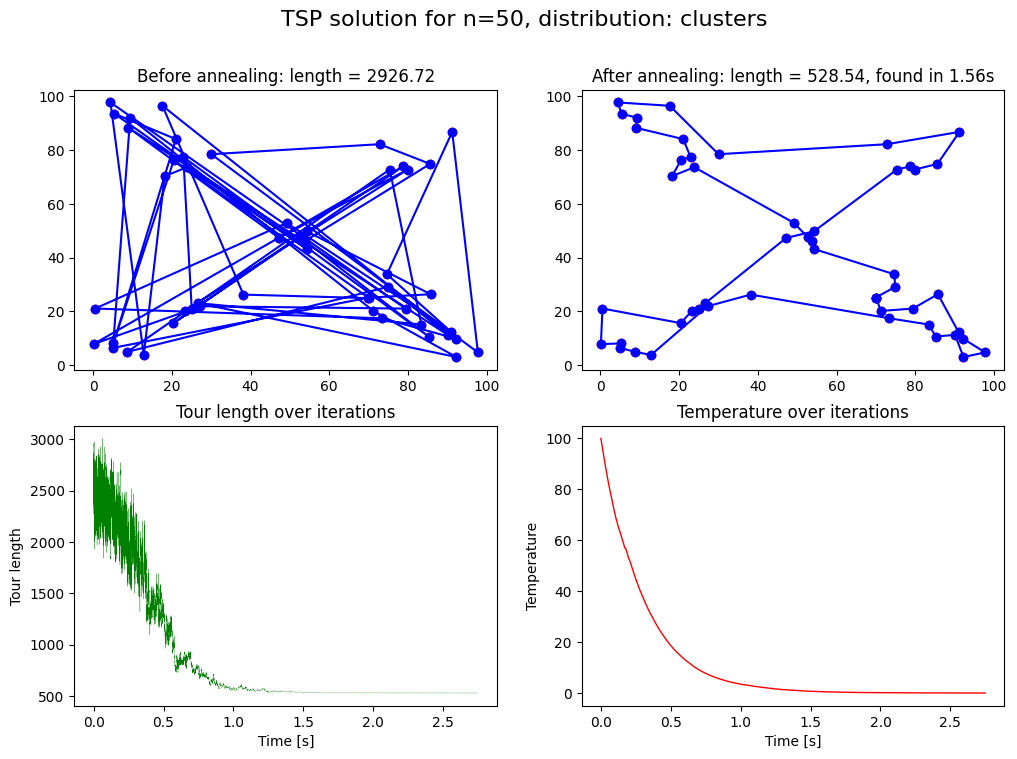

n=100
Distribution: uniform
Best tour length: 1017.59, found in 3.23s
Total elapsed time: 4.76s



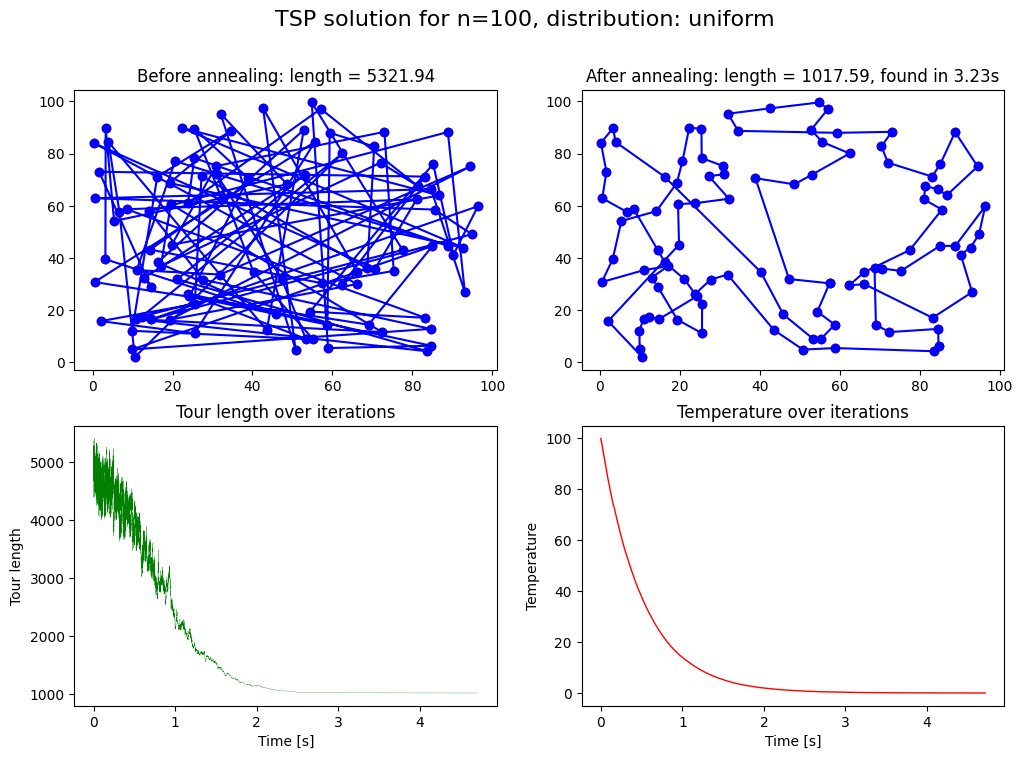

n=100
Distribution: normal
Best tour length: 1119.59, found in 4.06s
Total elapsed time: 4.79s



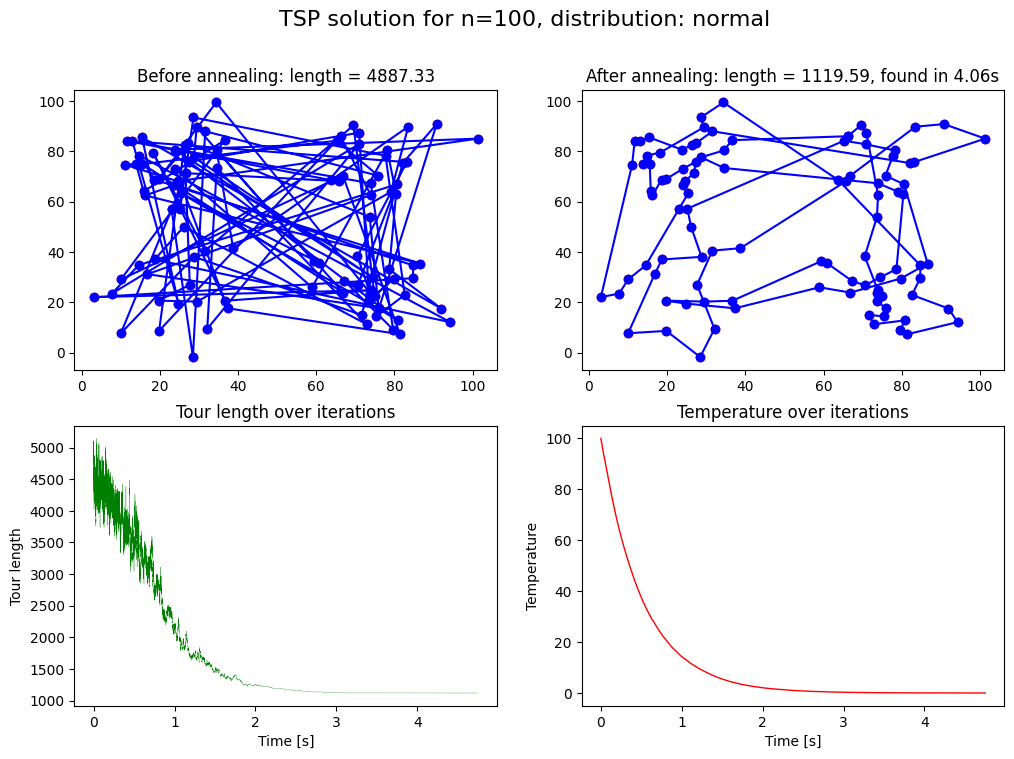

n=100
Distribution: clusters
Best tour length: 933.89, found in 4.15s
Total elapsed time: 4.77s



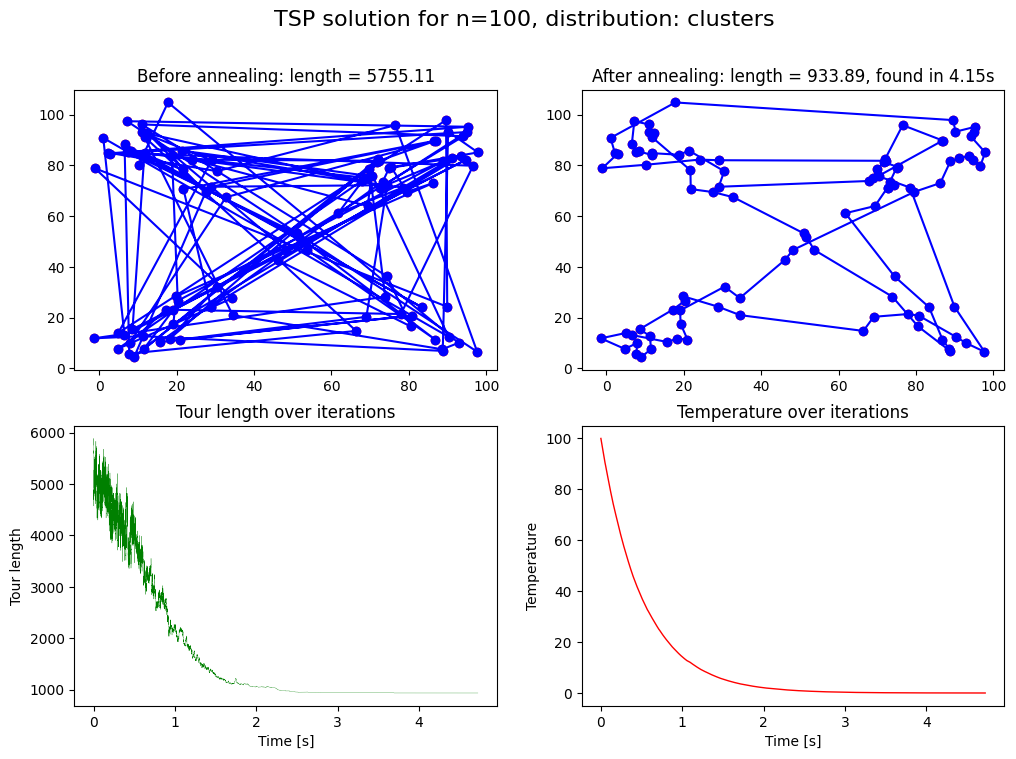

In [7]:
distributions = ["uniform", "normal", "clusters"]
n_values = [20, 50, 100]

for n in n_values:

    for dist in distributions:

        points = generate_points(n, dist)
        start = time.time()
        best_tour, best_length, found_time, initial_tour, initial_length,\
            lengths, temps = simulated_annealing(points)
        elapsed = time.time() - start

        print(f"n={n}")
        print(f"Distribution: {dist}")
        print(f"Best tour length: {best_length:.2f}, found in {found_time:.2f}s")
        print(f"Total elapsed time: {elapsed:.2f}s")
        print()

        plot_results(points, best_tour, best_length, found_time, 
                        initial_tour, initial_length, lengths, temps, n, dist)

## 2. Obraz binarny

Wygeneruj losowy obraz binarny o rozmiarze $n \times n$ i wybranej gęstości $δ$ czarnych punktów $δ = 0.1, 0.3, 0.4$. Korzystając z różnego typu sąsiedztwa (4-sąsiadów, 8-sąsiadów, 8-16-sąsiadów) zaproponuj funkcję energii (np. w bliskiej odległości te same kolory przyciągają się, a w dalszej odpychają się, funkcja energii może być również adaptacją modelu Isinga) i dokonaj jej minimalizacji za pomocą algorytmu symulowanego wyżarzania. W jaki sposób można generować stany sąsiednie? Jak różnią się uzyskane wyniki w zależności od rodzaju sąsiedztwa, wybranej funkcji energii i szybkości spadku temperatury?

## 3. Sudoku

Napisz program poszukujący rozwiązania łamigłówki Sudoku za pomocą symulowanego wyżarzania. Plansza $9 \times 9$ ma zostać wczytana z pliku tekstowego, w którym pola puste zaznaczone są znakiem `x`. Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występujących w wierszach bloku $9 \times 9$, kolumnach bloku $9 \times 9$ oraz blokach $3 \times 3$. Zaproponuj metodę generacji stanu sąsiedniego. Przedstaw zależność liczby iteracji algorytmu od liczby pustych miejsc na planszy. Czy Twój program jest w stanie znaleźć poprawne rozwiązanie dla każdej z testowanych konfiguracji wejściowych?